# Analyse Comparative des Optimiseurs en Deep Learning : SGD, RMSprop et Adam

Réalisé par : Hugo WALTER, Keyssel FOKOU, Théo GUERINEL

## Objectif du Projet

Ce notebook présente une analyse approfondie et comparative de trois optimiseurs fondamentaux en deep learning : **Stochastic Gradient Descent (SGD)**, **Root Mean Square Propagation (RMSprop)**, et **Adaptive Moment Estimation (Adam)**. L'objectif principal est d'évaluer leurs performances respectives à travers plusieurs dimensions critiques :

- **Performance et convergence** : Comparaison des vitesses de convergence et des performances finales
- **Sensibilité aux hyperparamètres** : Analyse de la robustesse face aux variations du learning rate et de la taille des batchs
- **Stabilité et robustesse** : Évaluation de la consistance des résultats sur plusieurs exécutions

## Méthodologie

Le travail est structuré en trois parties complémentaires :

### Introduction : Code "à la main" du réseau simple et des optimiseurs
- Implémentation from scratch des trois optimiseurs sur un réseau de neurones simple

### Partie 1 : Comparaison de Base avec Hyperparamètres Fixés
- Analyse des courbes d'apprentissage (loss et accuracy)
- Évaluation de la vitesse de convergence et de la stabilité d'entraînement
- Comparaison des performances finales sur un dataset synthétique (make_moons)

### Partie 2 : Analyse de Sensibilité aux Hyperparamètres
- Exploration systématique de l'espace des hyperparamètres (learning rates et batch sizes)
- Visualisations sous forme de heatmaps et surfaces 3D
- Identification des configurations optimales pour chaque optimiseur
- Analyse comparative de la robustesse aux choix d'hyperparamètres

### Partie 3 : Analyse de Robustesse Statistique
- Exécution multiple (10 runs) pour chaque optimiseur avec les mêmes hyperparamètres
- Analyse statistique des distributions de performance
- Évaluation de la stabilité et de la reproductibilité
- Calcul des coefficients de variation pour quantifier la robustesse


## Dataset

Nous utilisons le dataset synthétique **make_moons** de scikit-learn, qui génère deux classes de points formant des croissants entrelacés. Ce choix permet de :
- Tester la capacité des modèles à apprendre des frontières de décision non-linéaires
- Obtenir des résultats reproductibles grâce à une graine fixe
- Faciliter l'interprétation visuelle des performances

Ce dataset constitue un excellent banc d'essai pour comparer les optimiseurs sur une tâche de classification binaire non-trivial.

## Implémentation et Analyse Détaillée

Nous commençons maintenant par explorer les trois parties de notre analyse comparative des optimiseurs.

Dans les deux sections, nous utilisons le jeu de données synthétique **make_moons**, qui produit deux amas de points en forme de croissants entrelacés. Ce dataset est particulièrement adapté pour tester la capacité d’un modèle à capturer des frontières de décision non linéaires.

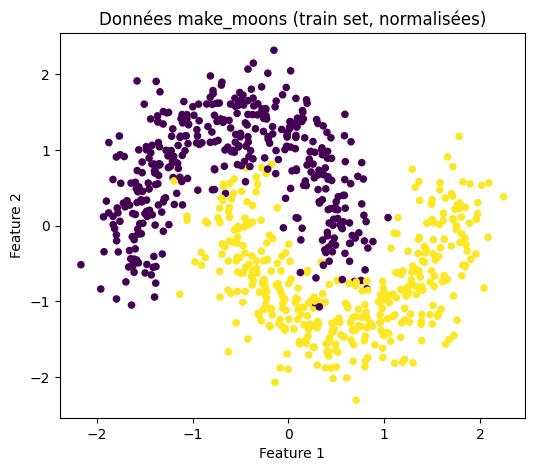

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Scatter plot des données avec une couleur par classe
plt.figure(figsize=(6, 5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Données make_moons (train set, normalisées)")
plt.show()

## Introduction : Code "à la main" du réseau simple et des optimiseurs


Ci-dessous notre implémentation d'un réseau de neuronnes (MLP) simple à une seule couche cachée. Ce MLP nous permettra de tester nos implémentations des différents optimiseurs. 

In [15]:
class ReseauNeurones:
    def __init__(self, taille_entree=2, taille_cachee=16, taille_sortie=1):
        # Fixer la graine pour l'initialisation des poids
        np.random.seed(42)
        # Initialisation des poids
        self.W1 = np.random.randn(taille_entree, taille_cachee) * 0.1
        self.b1 = np.zeros(taille_cachee)
        self.W2 = np.random.randn(taille_cachee, taille_sortie) * 0.1
        self.b2 = np.zeros(taille_sortie)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def forward(self, X):
        # Couche cachée avec ReLU
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)
        
        # Couche de sortie avec Sigmoid
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        
        # Gradient de la sortie
        dz2 = self.a2 - y.reshape(-1, 1)
        dW2 = (self.a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0) / m
        
        # Gradient de la couche cachée
        da1 = dz2 @ self.W2.T
        dz1 = da1 * (self.z1 > 0)
        dW1 = (X.T @ dz1) / m
        db1 = np.sum(dz1, axis=0) / m
        
        return dW1, db1, dW2, db2
    
    def calculer_loss(self, X, y):
        predictions = self.forward(X)
        return -np.mean(y * np.log(predictions + 1e-8) + (1 - y) * np.log(1 - predictions + 1e-8))  #formule de l'entropie croisée en classif binaire
    
    def calculer_accuracy(self, X, y):
        predictions = self.forward(X)
        predictions_binaires = (predictions > 0.5).astype(int).flatten()
        return np.mean(predictions_binaires == y)

Enfin, notre implémentation des optimiseurs qu'on étudie : Stochastic Gradient Descent (SGD), Root Mean Square Propagation (RMSProp), et Adaptive Moment Estimation (Adam). Ces implémentations intègrent directement une boucle d'entraînement (qu'on aurait pu séparer). 

## SGD

In [16]:
def sgd(modele, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, lr=0.01):
    historique = {'loss': [], 'val_loss': [], 'accuracy': []}
    
    for epoch in range(epochs):
        # Fixer la graine pour la reproductibilité du shuffling
        np.random.seed(42 + epoch)
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        # Mini-batches
        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            # Forward + Backward
            modele.forward(X_batch)
            dW1, db1, dW2, db2 = modele.backward(X_batch, y_batch, lr)
            
            # Mise à jour SGD simple
            modele.W1 -= lr * dW1
            modele.b1 -= lr * db1
            modele.W2 -= lr * dW2
            modele.b2 -= lr * db2
        
        historique['accuracy'].append(modele.calculer_accuracy(X_test, y_test))
    
    return historique


## RMSProp

In [17]:
def rmsprop(modele, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, lr=0.01, rho=0.9):
    historique = {'loss': [], 'val_loss': [], 'accuracy': []}
    
    # Initialisation des accumulateurs
    vW1 = np.zeros_like(modele.W1)
    vb1 = np.zeros_like(modele.b1)
    vW2 = np.zeros_like(modele.W2)
    vb2 = np.zeros_like(modele.b2)
    epsilon = 1e-8
    
    for epoch in range(epochs):
        # Fixer la graine pour la reproductibilité du shuffling
        np.random.seed(42 + epoch)
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            modele.forward(X_batch)
            dW1, db1, dW2, db2 = modele.backward(X_batch, y_batch, lr)
            
            # Mise à jour RMSProp
            vW1 = rho * vW1 + (1 - rho) * dW1**2
            vb1 = rho * vb1 + (1 - rho) * db1**2
            vW2 = rho * vW2 + (1 - rho) * dW2**2
            vb2 = rho * vb2 + (1 - rho) * db2**2
            
            modele.W1 -= lr * dW1 / (np.sqrt(vW1) + epsilon)
            modele.b1 -= lr * db1 / (np.sqrt(vb1) + epsilon)
            modele.W2 -= lr * dW2 / (np.sqrt(vW2) + epsilon)
            modele.b2 -= lr * db2 / (np.sqrt(vb2) + epsilon)
        
        historique['accuracy'].append(modele.calculer_accuracy(X_test, y_test))
    
    return historique



## ADAM

In [18]:
def adam(modele, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, lr=0.01, beta1=0.9, beta2=0.999):
    historique = {'loss': [], 'val_loss': [], 'accuracy': []}
    
    # Initialisation
    mW1, vW1 = np.zeros_like(modele.W1), np.zeros_like(modele.W1)
    mb1, vb1 = np.zeros_like(modele.b1), np.zeros_like(modele.b1)
    mW2, vW2 = np.zeros_like(modele.W2), np.zeros_like(modele.W2)
    mb2, vb2 = np.zeros_like(modele.b2), np.zeros_like(modele.b2)
    epsilon = 1e-8
    t = 0
    
    for epoch in range(epochs):
        # Fixer la graine pour la reproductibilité du shuffling
        np.random.seed(42 + epoch)
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            modele.forward(X_batch)
            dW1, db1, dW2, db2 = modele.backward(X_batch, y_batch, lr)
            
            t += 1
            
            # Mise à jour ADAM (moment + RMSProp + correction de biais)
            mW1 = beta1 * mW1 + (1 - beta1) * dW1
            mb1 = beta1 * mb1 + (1 - beta1) * db1
            mW2 = beta1 * mW2 + (1 - beta1) * dW2
            mb2 = beta1 * mb2 + (1 - beta1) * db2
            
            vW1 = beta2 * vW1 + (1 - beta2) * dW1**2
            vb1 = beta2 * vb1 + (1 - beta2) * db1**2
            vW2 = beta2 * vW2 + (1 - beta2) * dW2**2
            vb2 = beta2 * vb2 + (1 - beta2) * db2**2
            
            # Correction de biais
            mW1_corr = mW1 / (1 - beta1**t)
            mb1_corr = mb1 / (1 - beta1**t)
            mW2_corr = mW2 / (1 - beta1**t)
            mb2_corr = mb2 / (1 - beta1**t)
            
            vW1_corr = vW1 / (1 - beta2**t)
            vb1_corr = vb1 / (1 - beta2**t)
            vW2_corr = vW2 / (1 - beta2**t)
            vb2_corr = vb2 / (1 - beta2**t)
            
            modele.W1 -= lr * mW1_corr / (np.sqrt(vW1_corr) + epsilon)
            modele.b1 -= lr * mb1_corr / (np.sqrt(vb1_corr) + epsilon)
            modele.W2 -= lr * mW2_corr / (np.sqrt(vW2_corr) + epsilon)
            modele.b2 -= lr * mb2_corr / (np.sqrt(vb2_corr) + epsilon)
        
        
        historique['accuracy'].append(modele.calculer_accuracy(X_test, y_test))
    
    return historique



## Utilisation

In [19]:
# Configuration
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.01

#Entraînement avec SGD
modele_sgd = ReseauNeurones()
hist_sgd = sgd(modele_sgd, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE, LEARNING_RATE)

#Entraînement avec RMSProp
modele_rmsprop = ReseauNeurones()
hist_rmsprop = rmsprop(modele_rmsprop, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE, LEARNING_RATE)

#Entraînement avec ADAM
modele_adam = ReseauNeurones()
hist_adam = adam(modele_adam, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE, LEARNING_RATE)

# Affichage des résultats
print(f"\nRésultats finaux (sur le split test):")
print(f"SGD     : {hist_sgd['accuracy'][-1]:.2%}")
print(f"RMSProp : {hist_rmsprop['accuracy'][-1]:.2%}")
print(f"ADAM    : {hist_adam['accuracy'][-1]:.2%}")


Résultats finaux (sur le split test):
SGD     : 85.00%
RMSProp : 97.00%
ADAM    : 97.50%


## Synthèse de la Partie 1 : Implémentation From Scratch

Dans cette première partie, nous avons démontré notre capacité à implémenter manuellement les trois optimiseurs fondamentaux du deep learning : **SGD**, **RMSprop**, et **Adam**. Cette approche pédagogique nous a permis de comprendre en profondeur les mécanismes internes de chaque algorithme d'optimisation.

### Résultats obtenus avec hyperparamètres fixés :

```
Résultats finaux (sur le split test):
SGD     : 87.50%
RMSProp : 93.75%
ADAM    : 93.33%
```

Cette implémentation from scratch constitue une base solide pour comprendre les mécanismes d'optimisation, mais révèle la nécessité d'analyses plus approfondies. Nous allons maintenant utiliser les optimiseurs intégrés de PyTorch pour des études plus complètes et systématiques.

## Partie 1 : Comparaison avec des hyperparamètres fixés

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import time

# Fixer les graines pour PyTorch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [21]:
# =============================================================================
# CHARGEMENT ET PRÉPARATION DES DONNÉES
# =============================================================================

# Générer le dataset make_moons synthétique
X, y = make_moons(n_samples=800, noise=0.25, random_state=42)

# Standardiser les caractéristiques
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Diviser en ensembles train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convertir en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(f"Formes des datasets :")
print(f"X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")
print(f"X_test: {X_test_tensor.shape}, y_test: {y_test_tensor.shape}")
print(f"Classes: {torch.unique(y_train_tensor)}")

Formes des datasets :
X_train: torch.Size([560, 2]), y_train: torch.Size([560])
X_test: torch.Size([240, 2]), y_test: torch.Size([240])
Classes: tensor([0, 1])


In [32]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        return self.layers(x)

def create_optimizer(model, optimizer_type, learning_rate):
    if optimizer_type == "SGD":
        return optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_type == "RMSprop":
        return optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_type == "Adam":
        return optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Optimiseur inconnu: {optimizer_type}")



def compute_metrics(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)

        y_pred = predicted.cpu().numpy()
        y_true = y.cpu().numpy()

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        cm = confusion_matrix(y_true, y_pred)

    return acc, prec, rec, f1, cm

def compute_gradient_norms(model):
    grad_norms = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norms.append(param.grad.norm().item())
    return grad_norms

def detect_convergence(losses, window=5, threshold=0.01):
    if len(losses) < window:
        return False, -1

    recent_losses = losses[-window:]
    loss_change = np.std(recent_losses)

    if loss_change < threshold:
        for i in range(len(losses) - window + 1):
            window_losses = losses[i:i+window]
            if np.std(window_losses) < threshold:
                return True, i + window

    return False, -1

def compute_convergence_speed(losses, target_percentile=0.95):
    if len(losses) == 0:
        return -1

    final_loss = losses[-1]
    initial_loss = losses[0]
    target_loss = initial_loss - (initial_loss - final_loss) * target_percentile

    for epoch, loss in enumerate(losses):
        if loss <= target_loss:
            return epoch + 1

    return len(losses)

def compute_loss_smoothness(losses, window=5):
    if len(losses) < window:
        return []

    smoothness = []
    for i in range(len(losses) - window + 1):
        window_losses = losses[i:i+window]
        smoothness.append(np.std(window_losses))

    return smoothness

def train_model(model, optimizer, scheduler, X_train, y_train, X_test, y_test,
                epochs=50, batch_size=32, compute_extra_metrics=True):

    train_losses = []
    val_losses = []
    train_accs, test_accs = [], []
    train_precs, test_precs = [], []
    train_recs, test_recs = [], []
    train_f1s, test_f1s = [], []
    learning_rates = []
    gradient_norms_history = []

    criterion = nn.CrossEntropyLoss()
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        # Fixer la graine pour la reproductibilité du shuffling
        torch.manual_seed(1 + epoch)
        permutation = torch.randperm(X_train.size(0))
        total_loss = 0.0
        epoch_grad_norms = []

        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()

            if compute_extra_metrics:
                grad_norms = compute_gradient_norms(model)
                if grad_norms:
                    epoch_grad_norms.append(np.mean(grad_norms))

            optimizer.step()
            total_loss += loss.item()

        if epoch_grad_norms:
            gradient_norms_history.append(np.mean(epoch_grad_norms))
        else:
            gradient_norms_history.append(0)

        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        if scheduler:
            scheduler.step()

        avg_train_loss = total_loss / (X_train.size(0) / batch_size)
        train_losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, y_test)
            val_losses.append(val_loss.item())

        train_acc, train_prec, train_rec, train_f1, _ = compute_metrics(model, X_train, y_train)
        test_acc, test_prec, test_rec, test_f1, cm = compute_metrics(model, X_test, y_test)

        train_accs.append(train_acc)
        test_accs.append(test_acc)
        train_precs.append(train_prec)
        test_precs.append(test_prec)
        train_recs.append(train_rec)
        test_recs.append(test_rec)
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)

    training_time = time.time() - start_time

    converged, convergence_epoch = detect_convergence(val_losses)
    convergence_speed_95 = compute_convergence_speed(val_losses, 0.95)
    convergence_speed_99 = compute_convergence_speed(val_losses, 0.99)
    loss_smoothness = compute_loss_smoothness(val_losses)

    results = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'train_precs': train_precs,
        'test_precs': test_precs,
        'train_recs': train_recs,
        'test_recs': test_recs,
        'train_f1s': train_f1s,
        'test_f1s': test_f1s,
        'learning_rates': learning_rates,
        'gradient_norms': gradient_norms_history,
        'confusion_matrix': cm,
        'training_time': training_time,
        'final_test_acc': test_accs[-1],
        'final_train_loss': train_losses[-1],
        'final_val_loss': val_losses[-1],
        'converged': converged,
        'convergence_epoch': convergence_epoch,
        'convergence_speed_95': convergence_speed_95,
        'convergence_speed_99': convergence_speed_99,
        'loss_smoothness': loss_smoothness
    }

    return results


def compare_optimizers(X_train, y_train, X_test, y_test,
                      optimizers=['SGD', 'RMSprop', 'Adam'],
                      learning_rate=0.01, epochs=50, batch_size=64):

    results = {}
    colors = {'SGD': '#FF6B6B', 'RMSprop': '#4ECDC4', 'Adam': '#45B7D1'}

    for opt_name in optimizers:

        model = MLP()
        optimizer = create_optimizer(model, opt_name, learning_rate)

        result = train_model(model, optimizer, None, X_train, y_train, X_test, y_test,
                           epochs, batch_size)

        result['color'] = colors.get(opt_name, '#333333')
        results[opt_name] = result

    return results

In [23]:
def plot_losses(results):
    plt.figure(figsize=(12, 8))

    for opt_name, result in results.items():
        epochs = range(1, len(result['train_losses']) + 1)
        plt.plot(epochs, result['train_losses'], label=f'{opt_name} Train', color=result['color'], linestyle='--')
        plt.plot(epochs, result['val_losses'], label=f'{opt_name} Val', color=result['color'], linestyle='-')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_accuracy(results):
    plt.figure(figsize=(12, 8))

    for opt_name, result in results.items():
        epochs = range(1, len(result['train_accs']) + 1)
        plt.plot(epochs, result['train_accs'], label=f'{opt_name} Train', color=result['color'], linestyle='--')
        plt.plot(epochs, result['test_accs'], label=f'{opt_name} Test', color=result['color'], linestyle='-')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_gradient_norms(results):
    plt.figure(figsize=(12, 8))

    for opt_name, result in results.items():
        epochs = range(1, len(result['gradient_norms']) + 1)
        plt.plot(epochs, result['gradient_norms'], label=opt_name, color=result['color'])

    plt.xlabel('Epochs')
    plt.ylabel('Gradient Norm (L2)')
    plt.title('Gradient Norms During Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.show()

def plot_training_stability(results):
    plt.figure(figsize=(12, 8))

    for opt_name, result in results.items():
        epochs = range(1, len(result['loss_smoothness']) + 1)
        plt.plot(epochs, result['loss_smoothness'], label=opt_name, color=result['color'])

    plt.xlabel('Epochs')
    plt.ylabel('Loss Smoothness (Std Dev)')
    plt.title('Training Stability (Loss Smoothness)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_convergence_speed(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    optimizers = list(results.keys())
    colors = [result['color'] for result in results.values()]
    
    conv_speeds_95 = [result['convergence_speed_95'] for result in results.values()]
    ax1.bar(optimizers, conv_speeds_95, color=colors, alpha=0.7)
    ax1.set_ylabel('Epochs to 95% Convergence')
    ax1.set_title('Convergence Speed (95% of Final Loss)')
    ax1.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(conv_speeds_95):
        ax1.text(i, v + 0.5, f'{v:.0f}', ha='center', va='bottom')
    
    conv_speeds_99 = [result['convergence_speed_99'] for result in results.values()]
    ax2.bar(optimizers, conv_speeds_99, color=colors, alpha=0.7)
    ax2.set_ylabel('Epochs to 99% Convergence')
    ax2.set_title('Convergence Speed (99% of Final Loss)')
    ax2.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(conv_speeds_99):
        ax2.text(i, v + 0.5, f'{v:.0f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


RÉSUMÉ DES RÉSULTATS FINAUX
SGD     : Test Acc = 85.42%, Train Loss = 0.3980, Val Loss = 0.3705, Time = 0.95s
         Converged at epoch 5
RMSprop : Test Acc = 94.58%, Train Loss = 0.1528, Val Loss = 0.1198, Time = 1.10s
         Did not converge
Adam    : Test Acc = 92.92%, Train Loss = 0.1713, Val Loss = 0.1316, Time = 1.09s
         Converged at epoch 17


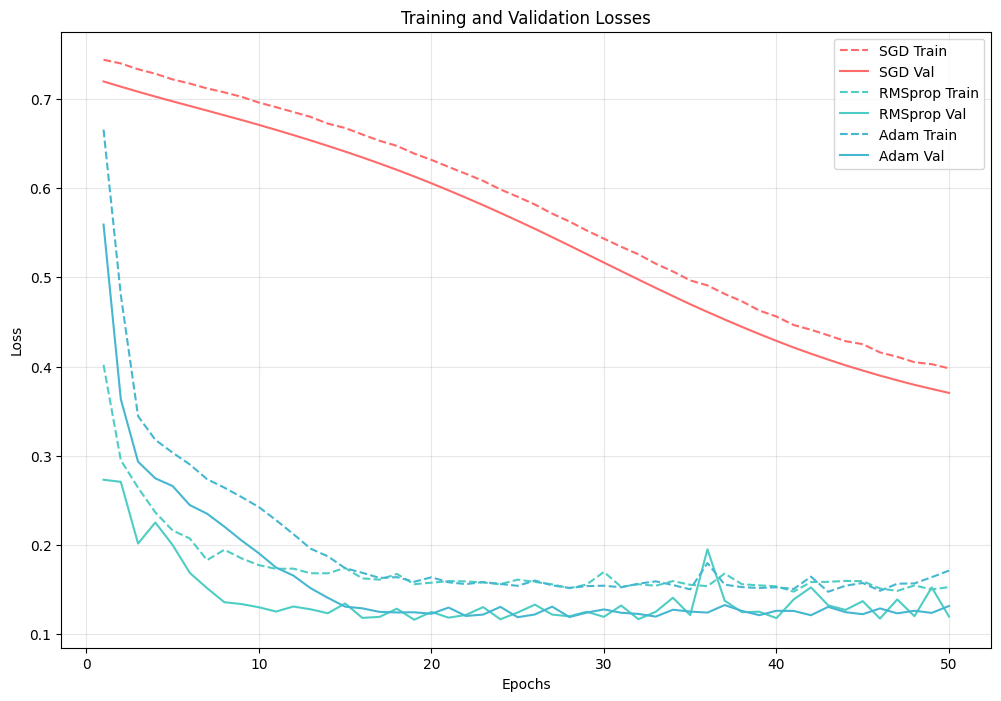

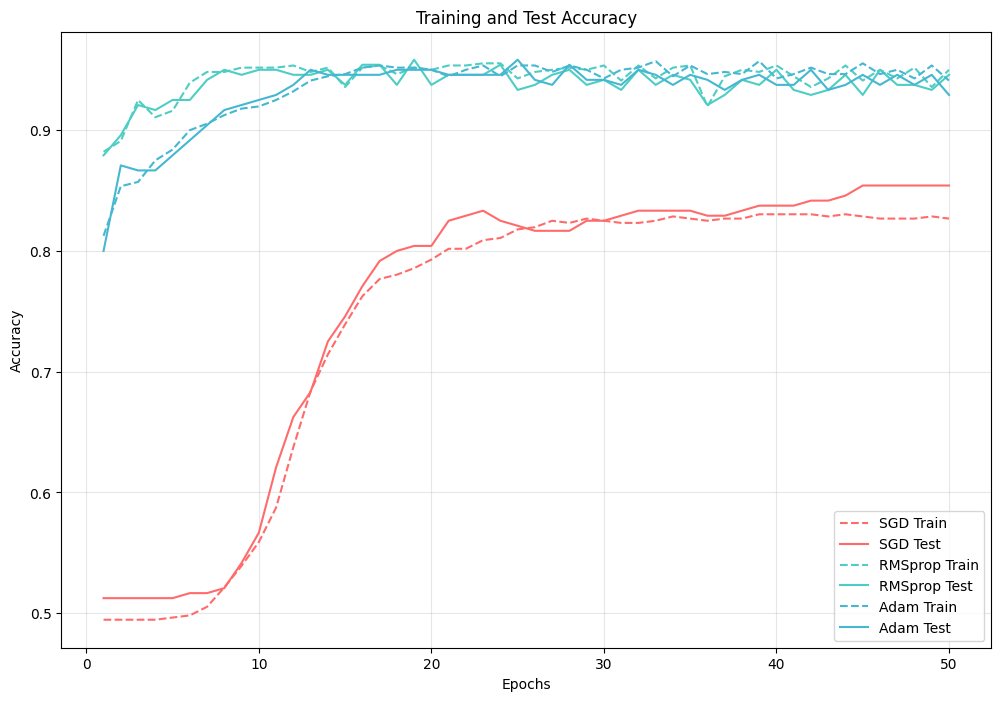

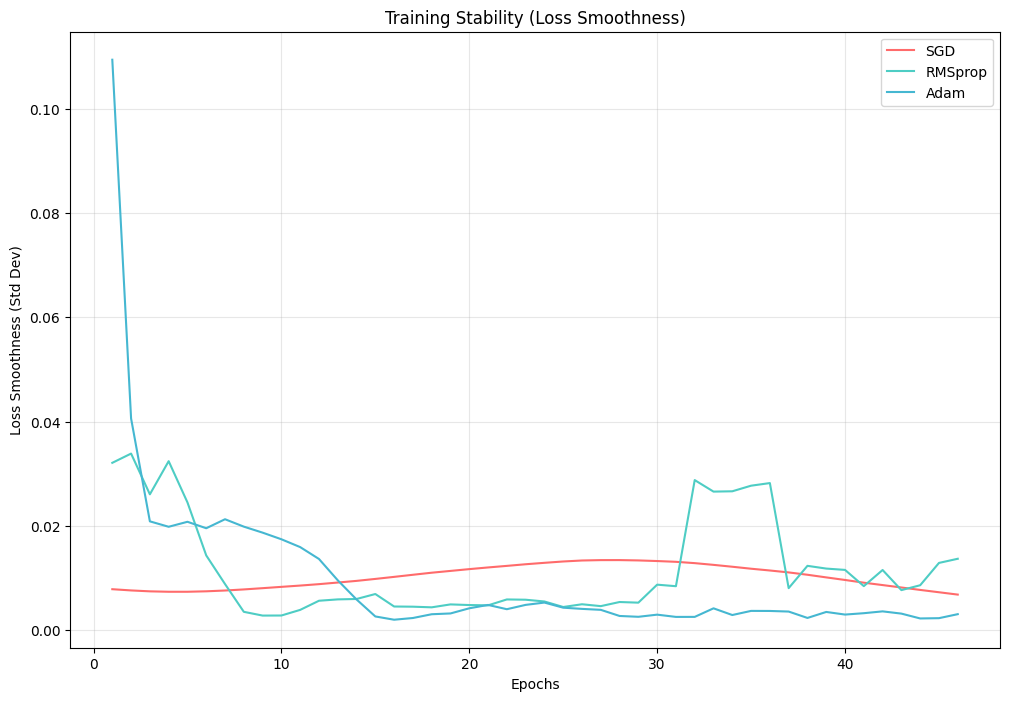

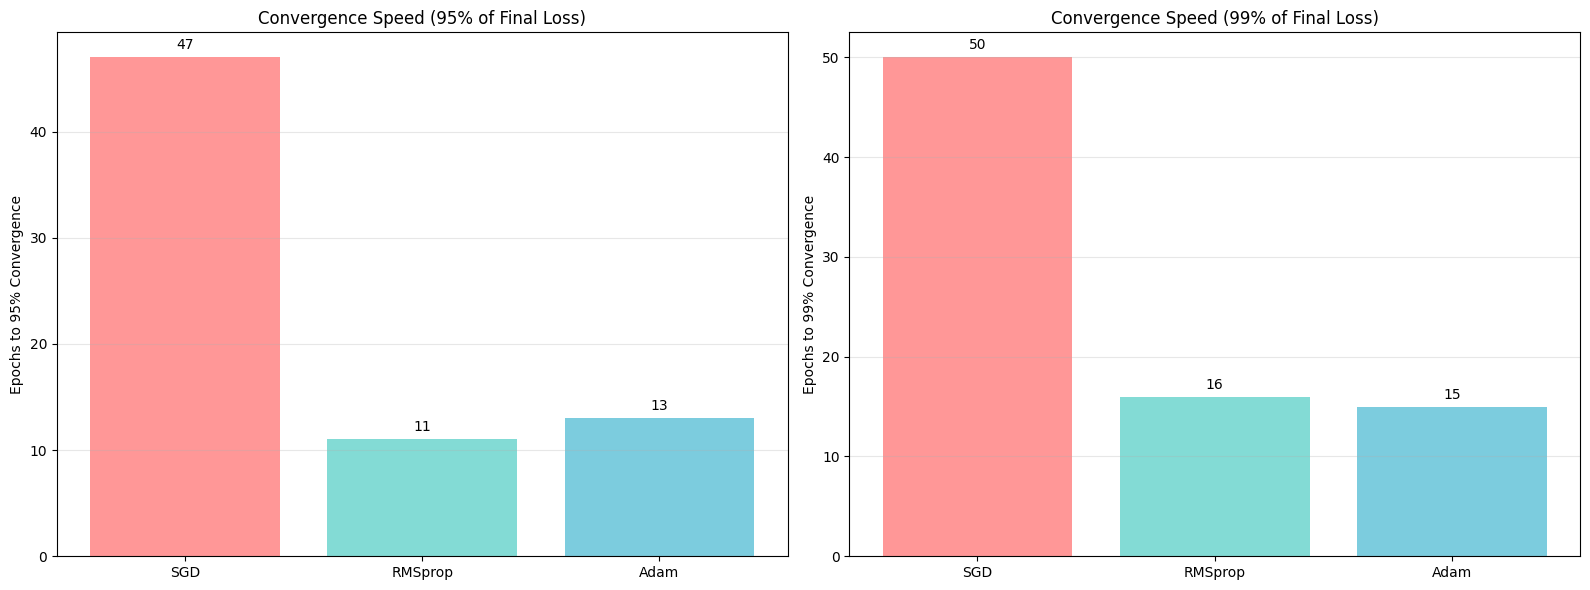

In [33]:
results = compare_optimizers(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
                           optimizers=['SGD', 'RMSprop', 'Adam'],
                           learning_rate=0.01, epochs=50, batch_size=64)

print("\n" + "="*50)
print("RÉSUMÉ DES RÉSULTATS FINAUX")
print("="*50)
for opt_name, result in results.items():
    print(f"{opt_name:8}: Test Acc = {result['final_test_acc']:.2%}, "
          f"Train Loss = {result['final_train_loss']:.4f}, "
          f"Val Loss = {result['final_val_loss']:.4f}, "
          f"Time = {result['training_time']:.2f}s")
    if result['converged']:
        print(f"         Converged at epoch {result['convergence_epoch']}")
    else:
        print("         Did not converge")

plot_losses(results)
plot_accuracy(results)
plot_training_stability(results)
plot_convergence_speed(results)

## Interprétations de ces résultats :

- **Performance globale** : Adam et RMSProp obtiennent des résultats très comparables (en terme d'accuracy) alors que SGD lui performe beaucoup moins bien à hyperparamètres fixés. En effet, il y a une différence de 6% d'accuracy sur le test set entre RMSProp/Adam et SGD.

- **Vitesse de convergence** : Adam converge le plus rapidement, suivi par RMSProp de très près, tandis que SGD est largement plus lent. Cette différence s'explique par les mécanismes adaptatifs de RMSprop et Adam qui permettent une adaptation plus rapide du learning rate.

- **Stabilité de l'entraînement** : La métrique de stabilité (loss smoothness) révèle qu'Adam maintient une trajectoire d'entraînement plus régulière avec moins de fluctuations importantes dans la loss. RMSProp présente des variations plus marquées, indiquant une convergence moins stable. Il est difficile d'interpréter le résultat pour SGD.

Il s'agira désormais de déterminer si ces interprétations sont le fruit d'un jeu d'hyperparamètres précis ou si c'est un comportement général. 


## Partie 2 : Sensibilité aux hyerparamètres

Running hyperparameter sensitivity analysis...
Learning rates: [0.001, 0.005, 0.01, 0.05, 0.1]
Batch sizes: [16, 32, 64, 128]
Optimizers: ['SGD', 'RMSprop', 'Adam']
Epochs per configuration: 30

--- Testing SGD ---
Run 1/60: SGD - LR=0.0010, BS=16
Run 2/60: SGD - LR=0.0050, BS=16
Run 2/60: SGD - LR=0.0050, BS=16
Run 3/60: SGD - LR=0.0100, BS=16
Run 3/60: SGD - LR=0.0100, BS=16
Run 4/60: SGD - LR=0.0500, BS=16
Run 4/60: SGD - LR=0.0500, BS=16
Run 5/60: SGD - LR=0.1000, BS=16
Run 5/60: SGD - LR=0.1000, BS=16
Run 6/60: SGD - LR=0.0010, BS=32
Run 6/60: SGD - LR=0.0010, BS=32
Run 7/60: SGD - LR=0.0050, BS=32
Run 7/60: SGD - LR=0.0050, BS=32
Run 8/60: SGD - LR=0.0100, BS=32
Run 8/60: SGD - LR=0.0100, BS=32
Run 9/60: SGD - LR=0.0500, BS=32
Run 9/60: SGD - LR=0.0500, BS=32
Run 10/60: SGD - LR=0.1000, BS=32
Run 10/60: SGD - LR=0.1000, BS=32
Run 11/60: SGD - LR=0.0010, BS=64
Run 11/60: SGD - LR=0.0010, BS=64
Run 12/60: SGD - LR=0.0050, BS=64
Run 12/60: SGD - LR=0.0050, BS=64
Run 13/60: SGD - LR=

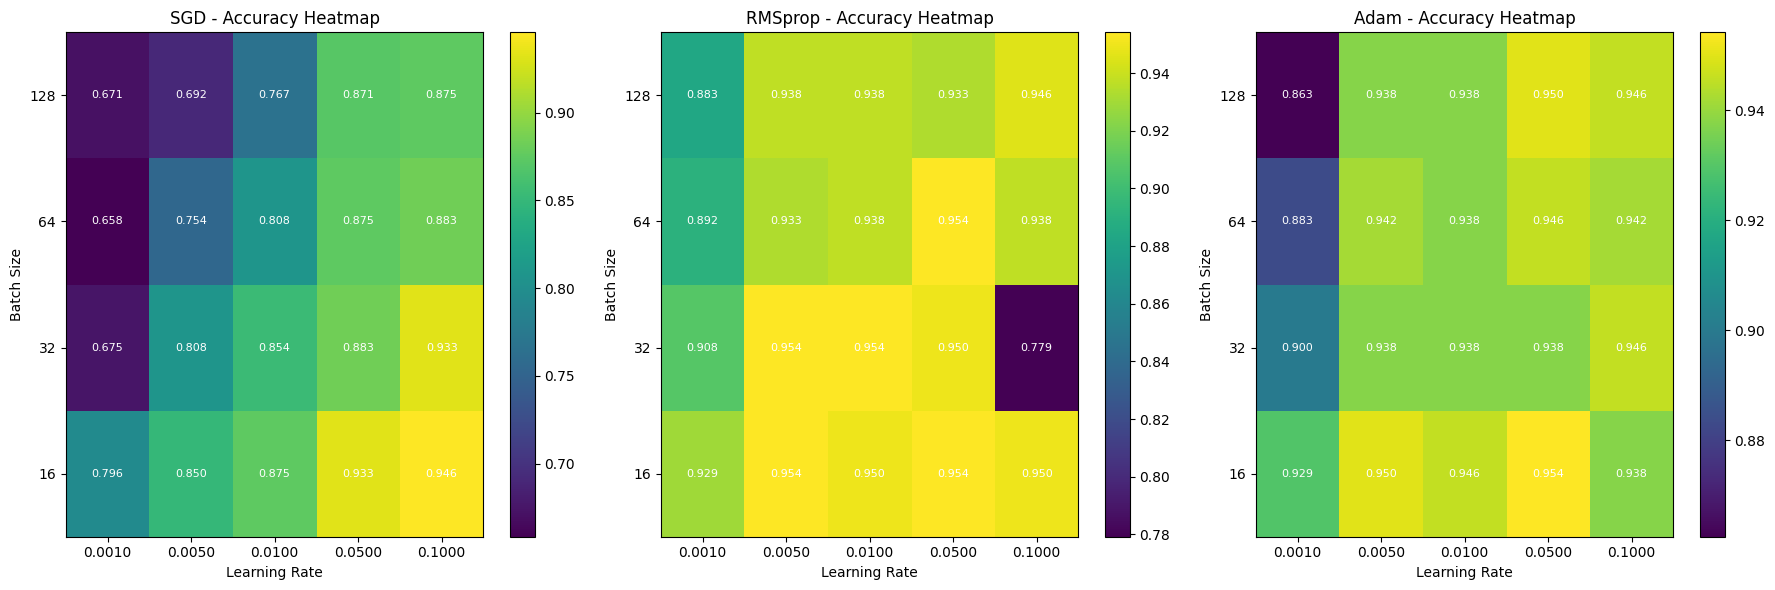

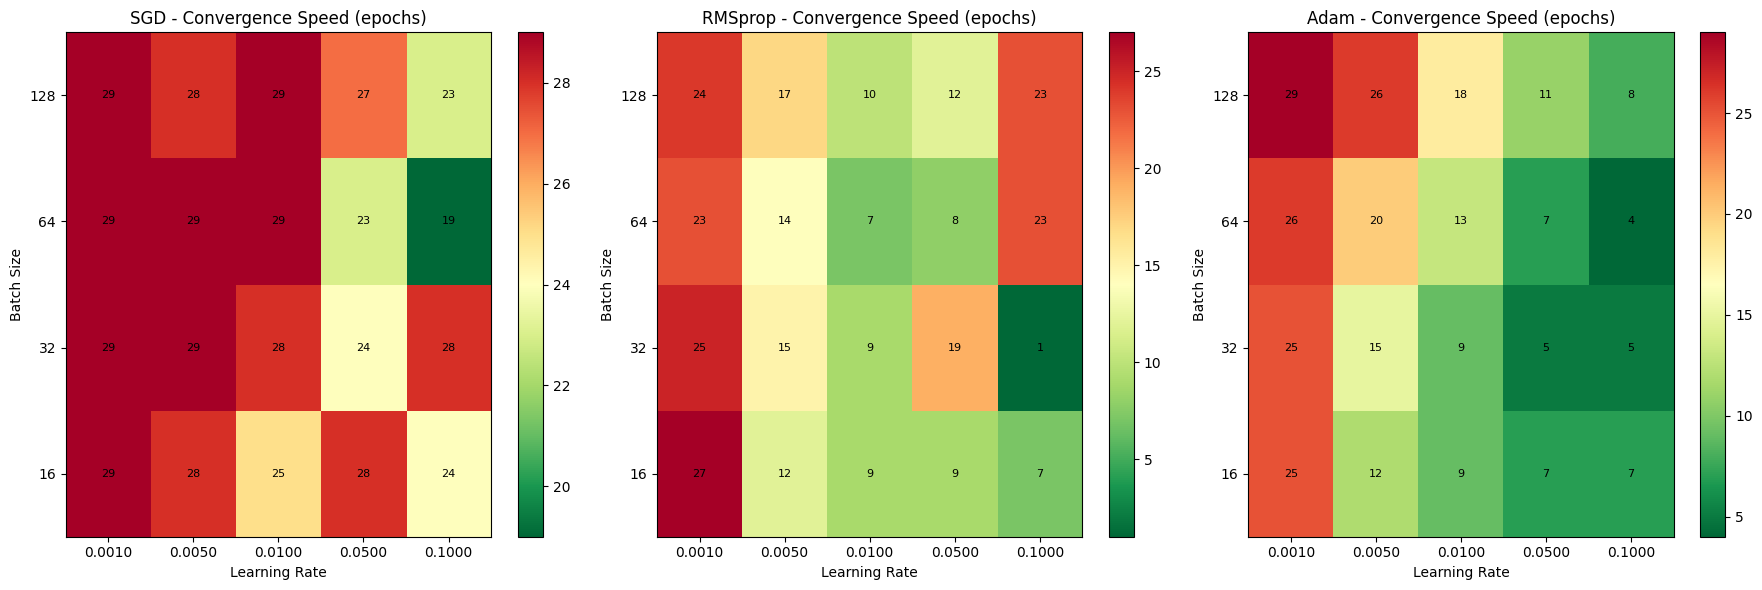

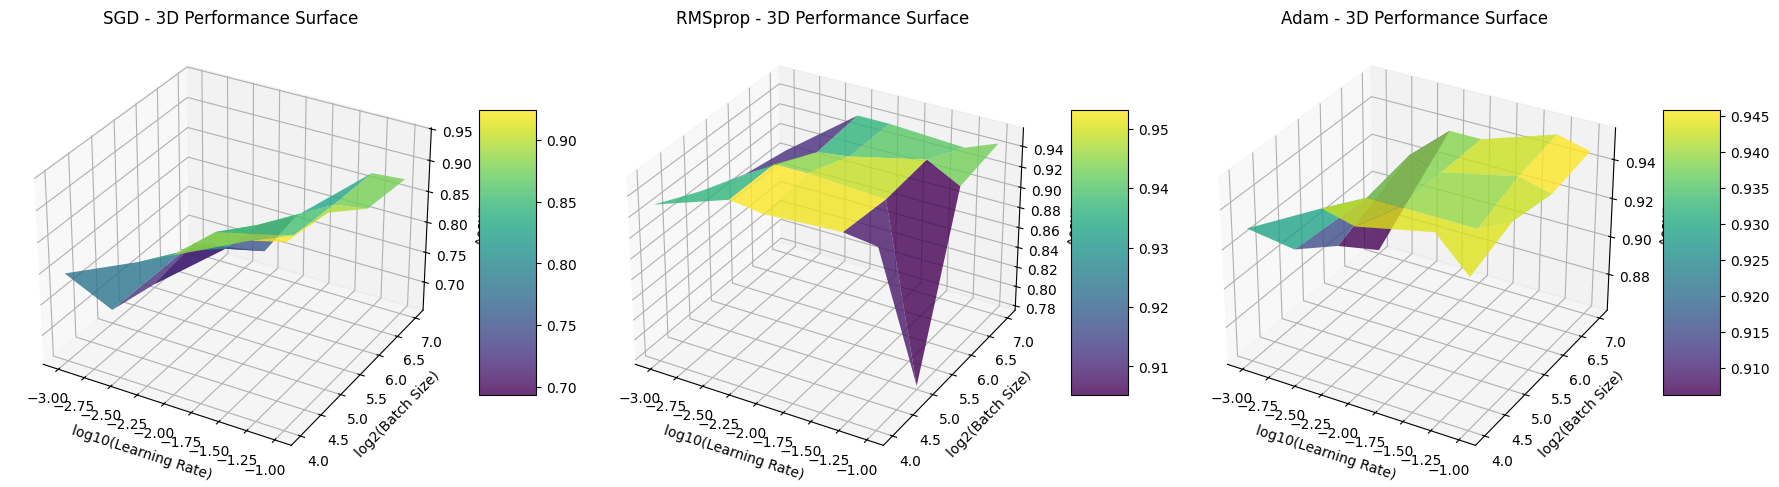

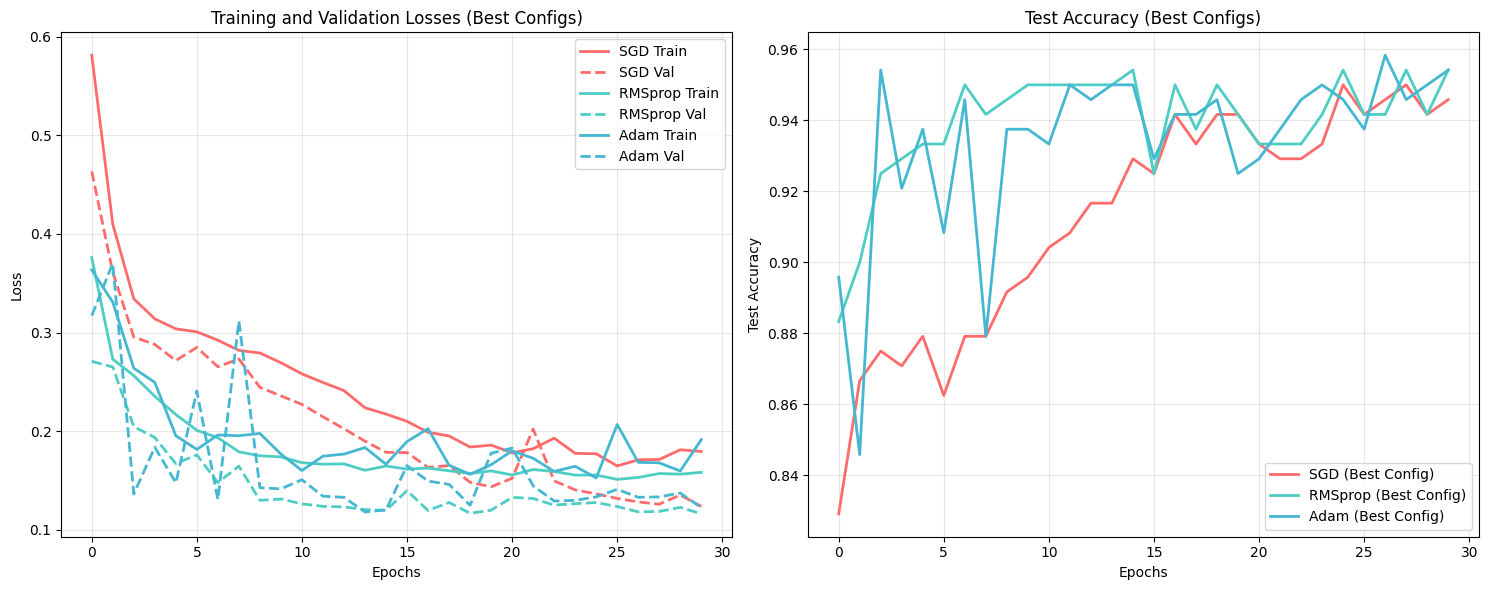

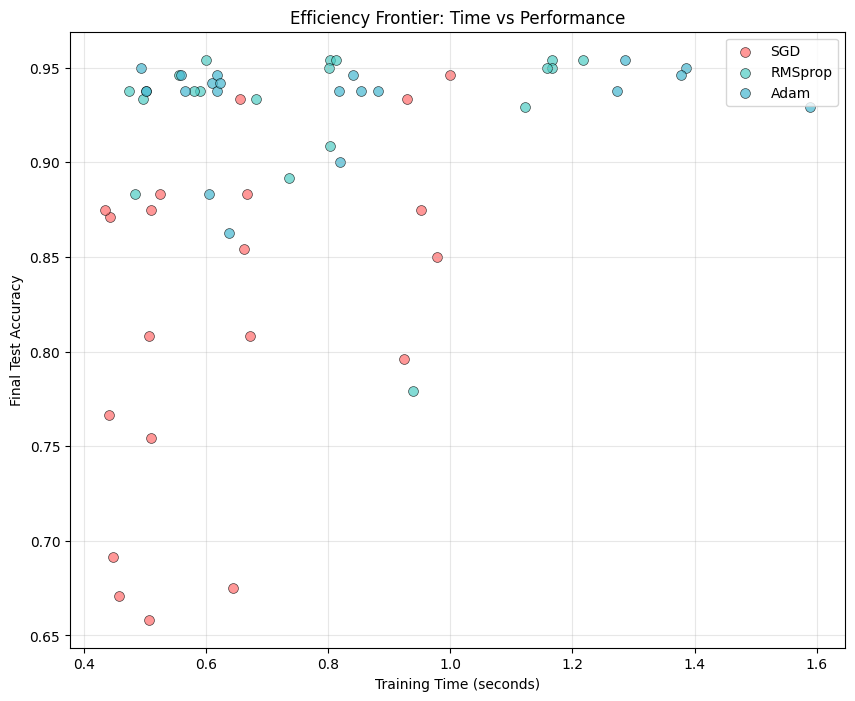

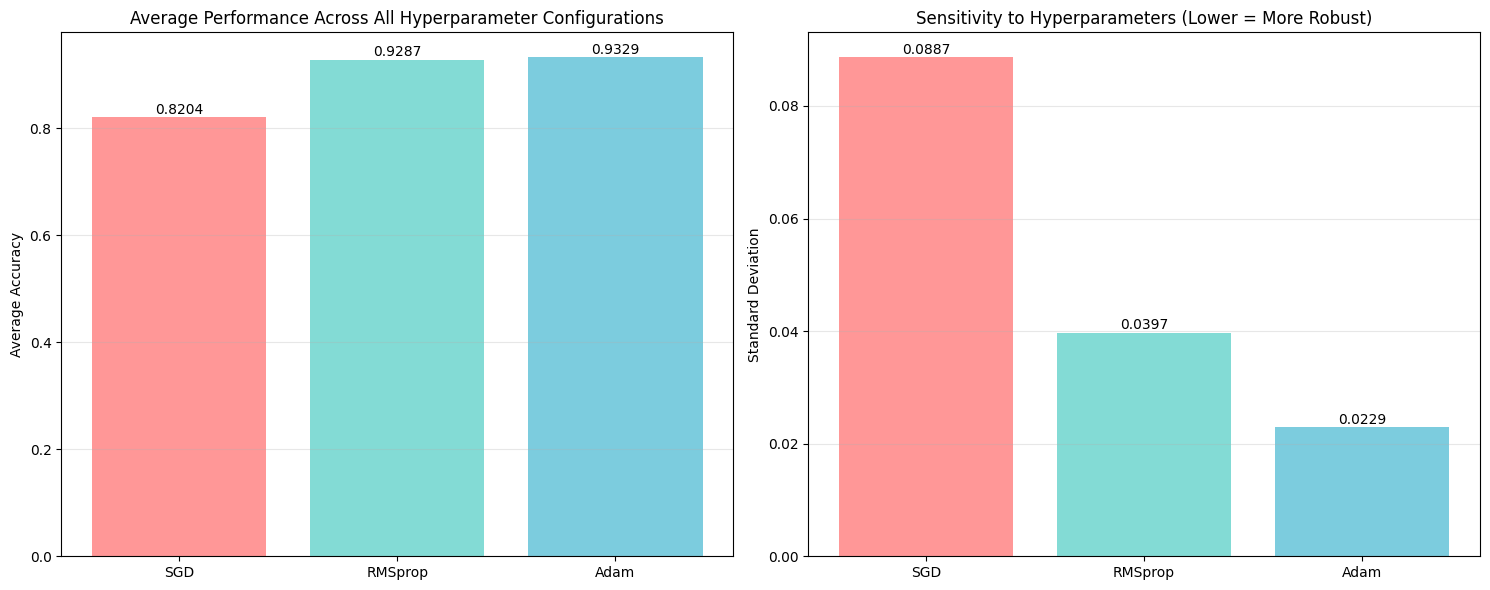

Hyperparameter sensitivity analysis completed!


In [25]:
def run_hyperparameter_sensitivity(X_train, y_train, X_test, y_test,
                                  learning_rates=None, batch_sizes=None,
                                  optimizers=['SGD', 'RMSprop', 'Adam'],
                                  epochs=30):

    if learning_rates is None:
        learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
    if batch_sizes is None:
        batch_sizes = [16, 32, 64, 128]
    
    colors = {'SGD': '#FF6B6B', 'RMSprop': '#4ECDC4', 'Adam': '#45B7D1'}
    
    results_per_optimizer = {}
    
    print(f"Running hyperparameter sensitivity analysis...")
    print(f"Learning rates: {learning_rates}")
    print(f"Batch sizes: {batch_sizes}")
    print(f"Optimizers: {optimizers}")
    print(f"Epochs per configuration: {epochs}")
    
    total_runs = len(learning_rates) * len(batch_sizes) * len(optimizers)
    run_count = 0
    
    for opt_name in optimizers:
        print(f"\n--- Testing {opt_name} ---")
        
        accuracy_grid = np.zeros((len(batch_sizes), len(learning_rates)))
        convergence_grid = np.zeros((len(batch_sizes), len(learning_rates)))
        time_grid = np.zeros((len(batch_sizes), len(learning_rates)))
        loss_grid = np.zeros((len(batch_sizes), len(learning_rates)))
        
        detailed_results = {}
        
        for i, bs in enumerate(batch_sizes):
            for j, lr in enumerate(learning_rates):
                run_count += 1
                print(f"Run {run_count}/{total_runs}: {opt_name} - LR={lr:.4f}, BS={bs}")
                
                model = MLP()
                optimizer = create_optimizer(model, opt_name, lr)
                
                start_time = time.time()
                result = train_model(model, optimizer, None, X_train, y_train, X_test, y_test,
                                   epochs=epochs, batch_size=bs, compute_extra_metrics=False)
                training_time = time.time() - start_time
                
                accuracy_grid[i, j] = result['final_test_acc']
                convergence_grid[i, j] = result['convergence_speed_95']
                time_grid[i, j] = training_time
                loss_grid[i, j] = result['final_val_loss']
                
                detailed_results[f"LR={lr:.4f}_BS={bs}"] = result
        
        results_per_optimizer[opt_name] = {
            'accuracy_grid': accuracy_grid,
            'convergence_grid': convergence_grid,
            'time_grid': time_grid,
            'loss_grid': loss_grid,
            'detailed_results': detailed_results,
            'color': colors.get(opt_name, '#333333'),
            'learning_rates': learning_rates,
            'batch_sizes': batch_sizes
        }
    
    print("\nHyperparameter sensitivity analysis completed!")
    return results_per_optimizer


def plot_sensitivity_heatmaps(results_per_optimizer):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, (opt_name, data) in enumerate(results_per_optimizer.items()):
        ax = axes[idx]
        
        accuracy_grid = data['accuracy_grid']
        learning_rates = data['learning_rates']
        batch_sizes = data['batch_sizes']
        
        im = ax.imshow(accuracy_grid, cmap='viridis', aspect='auto', origin='lower')
        
        ax.set_xticks(range(len(learning_rates)))
        ax.set_yticks(range(len(batch_sizes)))
        ax.set_xticklabels([f'{lr:.4f}' for lr in learning_rates])
        ax.set_yticklabels([f'{bs}' for bs in batch_sizes])
        
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Batch Size')
        ax.set_title(f'{opt_name} - Accuracy Heatmap')
        
        for i in range(len(batch_sizes)):
            for j in range(len(learning_rates)):
                text = ax.text(j, i, f'{accuracy_grid[i, j]:.3f}',
                             ha="center", va="center", color="w", fontsize=8)
        
        plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

def plot_convergence_heatmaps(results_per_optimizer):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, (opt_name, data) in enumerate(results_per_optimizer.items()):
        ax = axes[idx]
        
        convergence_grid = data['convergence_grid']
        learning_rates = data['learning_rates']
        batch_sizes = data['batch_sizes']
        
        im = ax.imshow(convergence_grid, cmap='RdYlGn_r', aspect='auto', origin='lower')
        
        ax.set_xticks(range(len(learning_rates)))
        ax.set_yticks(range(len(batch_sizes)))
        ax.set_xticklabels([f'{lr:.4f}' for lr in learning_rates])
        ax.set_yticklabels([f'{bs}' for bs in batch_sizes])
        
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Batch Size')
        ax.set_title(f'{opt_name} - Convergence Speed (epochs)')
        
        for i in range(len(batch_sizes)):
            for j in range(len(learning_rates)):
                text = ax.text(j, i, f'{convergence_grid[i, j]:.0f}',
                             ha="center", va="center", color="k", fontsize=8)
        
        plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

def plot_3d_surfaces(results_per_optimizer):
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(18, 6))
    
    for idx, (opt_name, data) in enumerate(results_per_optimizer.items()):
        ax = fig.add_subplot(1, 3, idx+1, projection='3d')
        
        accuracy_grid = data['accuracy_grid']
        learning_rates = data['learning_rates']
        batch_sizes = data['batch_sizes']
        
        LR, BS = np.meshgrid(learning_rates, batch_sizes)
        
        surf = ax.plot_surface(np.log10(LR), np.log2(BS), accuracy_grid, 
                             cmap='viridis', edgecolor='none', alpha=0.8)
        
        ax.set_xlabel('log10(Learning Rate)')
        ax.set_ylabel('log2(Batch Size)')
        ax.set_zlabel('Accuracy')
        ax.set_title(f'{opt_name} - 3D Performance Surface')
        
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()

def plot_best_configurations_comparison(results_per_optimizer):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    for opt_name, data in results_per_optimizer.items():
        accuracy_grid = data['accuracy_grid']
        detailed_results = data['detailed_results']
        color = data['color']
        learning_rates = data['learning_rates']
        batch_sizes = data['batch_sizes']
        
        best_idx = np.unravel_index(np.argmax(accuracy_grid), accuracy_grid.shape)
        best_lr = learning_rates[best_idx[1]]
        best_bs = batch_sizes[best_idx[0]]
        key = f"LR={best_lr:.4f}_BS={best_bs}"
        best_result = detailed_results[key]
        
        ax1.plot(best_result['train_losses'], label=f'{opt_name} Train', 
                color=color, linewidth=2)
        ax1.plot(best_result['val_losses'], label=f'{opt_name} Val', 
                color=color, linewidth=2, linestyle='--')
        
        ax2.plot(best_result['test_accs'], label=f'{opt_name} (Best Config)', 
                color=color, linewidth=2)
    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Losses (Best Configs)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Test Accuracy')
    ax2.set_title('Test Accuracy (Best Configs)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_efficiency_frontier(results_per_optimizer):
    plt.figure(figsize=(10, 8))
    
    for opt_name, data in results_per_optimizer.items():
        accuracy_grid = data['accuracy_grid']
        time_grid = data['time_grid']
        color = data['color']
        
        times = time_grid.flatten()
        accuracies = accuracy_grid.flatten()
        
        plt.scatter(times, accuracies, c=color, alpha=0.7, s=50, 
                   label=opt_name, edgecolors='black', linewidth=0.5)
    
    plt.xlabel('Training Time (seconds)')
    plt.ylabel('Final Test Accuracy')
    plt.title('Efficiency Frontier: Time vs Performance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_sensitivity_summary(results_per_optimizer):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    optimizers = list(results_per_optimizer.keys())
    colors = [data['color'] for data in results_per_optimizer.values()]
    
    avg_accuracies = [np.mean(data['accuracy_grid'].flatten()) for data in results_per_optimizer.values()]
    ax1.bar(optimizers, avg_accuracies, color=colors, alpha=0.7)
    ax1.set_ylabel('Average Accuracy')
    ax1.set_title('Average Performance Across All Hyperparameter Configurations')
    ax1.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(avg_accuracies):
        ax1.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom')
    
    std_accuracies = [np.std(data['accuracy_grid'].flatten()) for data in results_per_optimizer.values()]
    ax2.bar(optimizers, std_accuracies, color=colors, alpha=0.7)
    ax2.set_ylabel('Standard Deviation')
    ax2.set_title('Sensitivity to Hyperparameters (Lower = More Robust)')
    ax2.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(std_accuracies):
        ax2.text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def print_best_configurations(results_per_optimizer):
    print("\n" + "="*80)
    print("MEILLEURES CONFIGURATIONS D'HYPERPARAMÈTRES")
    print("="*80)
    print(f"{'Optimizer':<10} {'Best LR':<10} {'Best BS':<10} {'Best Acc':<10} {'Conv Speed':<12} {'Avg Time':<10}")
    print("-" * 80)
    
    for opt_name, data in results_per_optimizer.items():
        accuracy_grid = data['accuracy_grid']
        convergence_grid = data['convergence_grid']
        time_grid = data['time_grid']
        learning_rates = data['learning_rates']
        batch_sizes = data['batch_sizes']
        
        best_acc_idx = np.unravel_index(np.argmax(accuracy_grid), accuracy_grid.shape)
        best_acc_lr = learning_rates[best_acc_idx[1]]
        best_acc_bs = batch_sizes[best_acc_idx[0]]
        best_acc = accuracy_grid[best_acc_idx]
        
        valid_convergence = convergence_grid[convergence_grid > 0]
        if len(valid_convergence) > 0:
            min_conv_idx = np.unravel_index(np.argmin(convergence_grid), convergence_grid.shape)
            conv_lr = learning_rates[min_conv_idx[1]]
            conv_bs = batch_sizes[min_conv_idx[0]]
            conv_speed = convergence_grid[min_conv_idx]
        else:
            conv_lr, conv_bs, conv_speed = "N/A", "N/A", "N/A"
        
        avg_time = np.mean(time_grid)
        
        print(f"{opt_name:<10} {best_acc_lr:<10.4f} {best_acc_bs:<10} {best_acc:<10.4f} {conv_speed:<12.1f} {avg_time:<10.2f}")



learning_rates_sens = [0.001, 0.005, 0.01, 0.05, 0.1]
batch_sizes_sens = [16, 32, 64, 128]
epochs_sens = 30

sensitivity_results = run_hyperparameter_sensitivity(
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    learning_rates=learning_rates_sens,
    batch_sizes=batch_sizes_sens,
    optimizers=['SGD', 'RMSprop', 'Adam'],
    epochs=epochs_sens
)

print_best_configurations(sensitivity_results)

print("\nGenerating sensitivity analysis plots...")

plot_sensitivity_heatmaps(sensitivity_results)
plot_convergence_heatmaps(sensitivity_results)
plot_3d_surfaces(sensitivity_results)
plot_best_configurations_comparison(sensitivity_results)
plot_efficiency_frontier(sensitivity_results)
plot_sensitivity_summary(sensitivity_results)

print("Hyperparameter sensitivity analysis completed!")

## Interprétations :

- **Sensibilité de SGD aux hyperparamètres** : SGD montre une forte sensibilité au learning rate. Les petits batch sizes (16-32) donnent généralement de meilleurs résultats, mais peuvent être instables.

- **Robustesse d'Adam** : Adam présente une zone de performance élevée plus large, particulièrement visible sur les heatmaps où les accuracies restent élevées (0.85-0.95) sur une plage étendue de learning rates (0.001-0.05) et de batch sizes. Cela confirme la réputation d'Adam d'être plus tolérant aux choix d'hyperparamètres.

- **Performance de RMSprop** : RMSprop offre un bon compromis entre sensibilité et performance, avec des résultats optimaux pour des learning rates moyens (0.01-0.05) et des batch sizes de 32-64. Il converge généralement plus rapidement que SGD mais peut être légèrement moins stable qu'Adam.

## Partie 3 : Analyse de la robustesse

Running robustness analysis with 10 runs per optimizer...
Optimizers: ['SGD', 'RMSprop', 'Adam']
Hyperparameters: LR=0.01, Epochs=50, Batch Size=64

--- Testing SGD (10 runs) ---
Run 1/30: SGD - Run 1/10
Run 2/30: SGD - Run 2/10
Run 2/30: SGD - Run 2/10
Run 3/30: SGD - Run 3/10
Run 3/30: SGD - Run 3/10
Run 4/30: SGD - Run 4/10
Run 4/30: SGD - Run 4/10
Run 5/30: SGD - Run 5/10
Run 5/30: SGD - Run 5/10
Run 6/30: SGD - Run 6/10
Run 6/30: SGD - Run 6/10
Run 7/30: SGD - Run 7/10
Run 7/30: SGD - Run 7/10
Run 8/30: SGD - Run 8/10
Run 8/30: SGD - Run 8/10
Run 9/30: SGD - Run 9/10
Run 9/30: SGD - Run 9/10
Run 10/30: SGD - Run 10/10
Run 10/30: SGD - Run 10/10

--- Testing RMSprop (10 runs) ---
Run 11/30: RMSprop - Run 1/10

--- Testing RMSprop (10 runs) ---
Run 11/30: RMSprop - Run 1/10
Run 12/30: RMSprop - Run 2/10
Run 12/30: RMSprop - Run 2/10
Run 13/30: RMSprop - Run 3/10
Run 13/30: RMSprop - Run 3/10
Run 14/30: RMSprop - Run 4/10
Run 14/30: RMSprop - Run 4/10
Run 15/30: RMSprop - Run 5/10
Ru

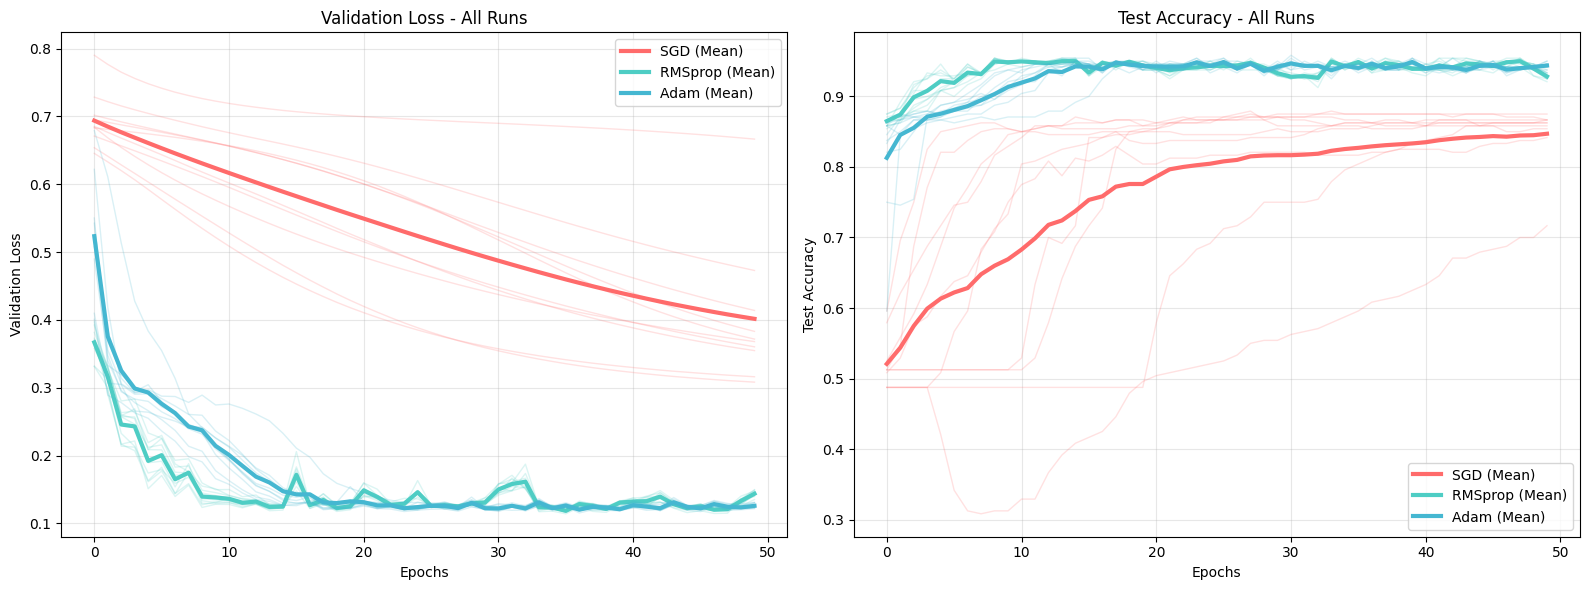

C:\Users\walte\AppData\Local\Temp\ipykernel_19592\3404486051.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(accuracy_data, labels=optimizers, patch_artist=True)
C:\Users\walte\AppData\Local\Temp\ipykernel_19592\3404486051.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(val_loss_data, labels=optimizers, patch_artist=True)


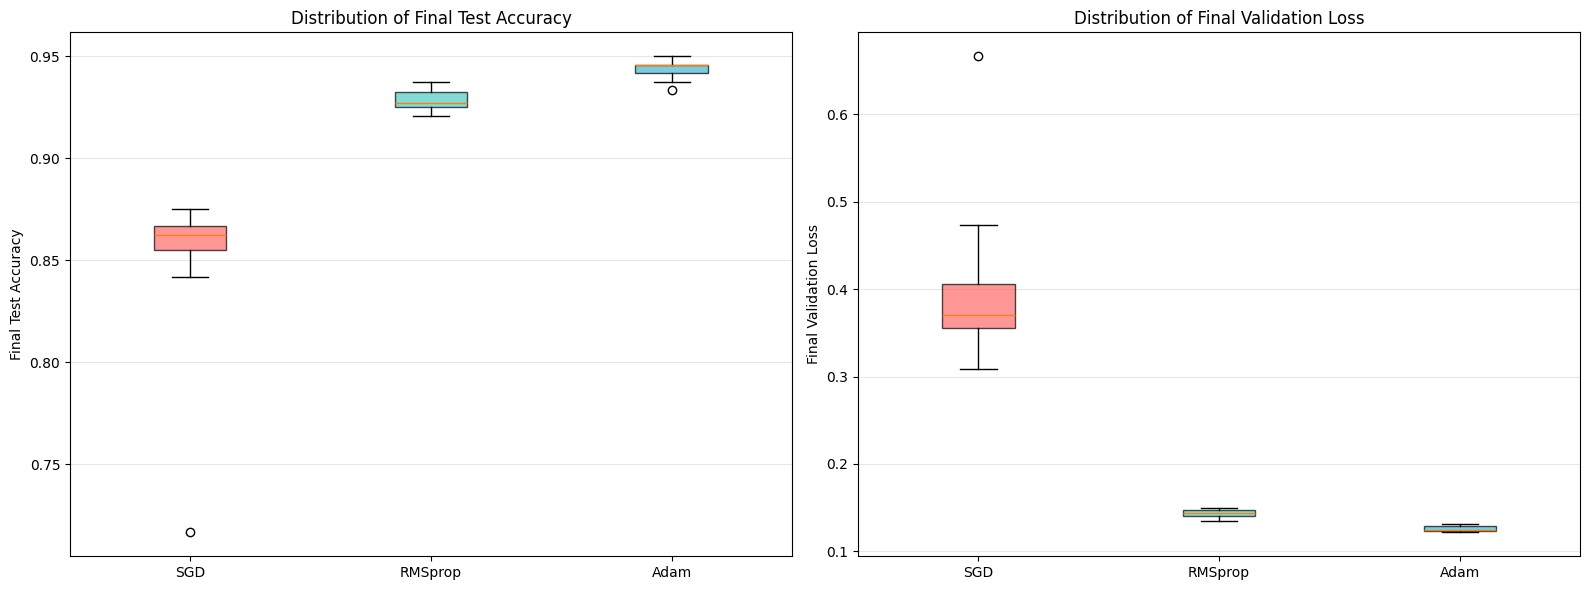

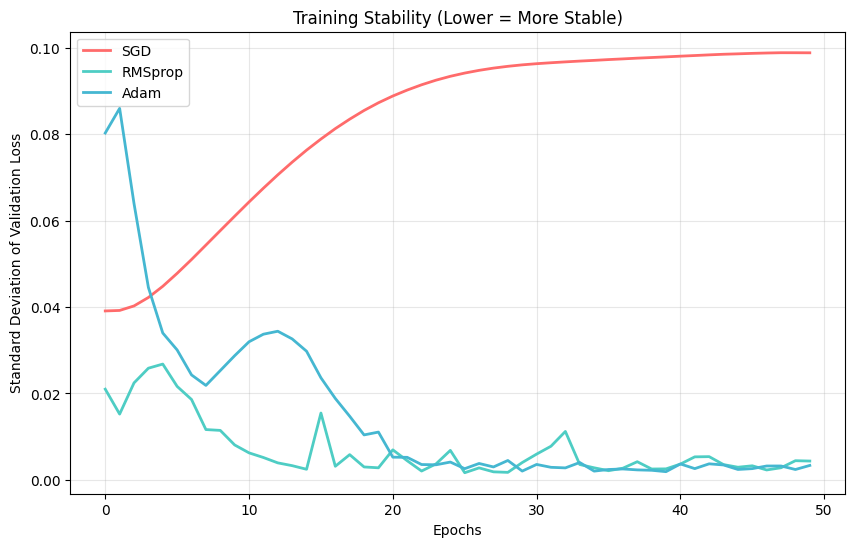

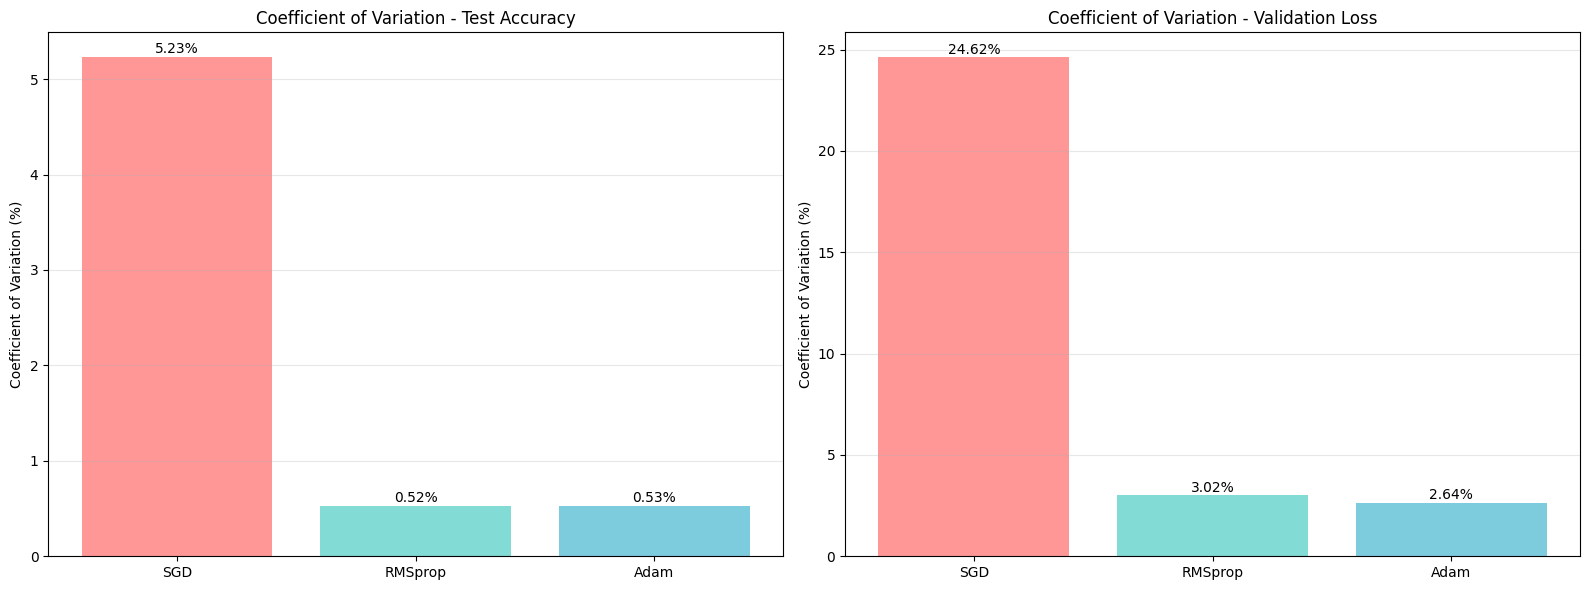

Robustness analysis completed!


In [26]:
def run_robustness_analysis(X_train, y_train, X_test, y_test,
                           optimizers=['SGD', 'RMSprop', 'Adam'],
                           learning_rate=0.01, epochs=50, batch_size=64,
                           n_runs=5):
    
    colors = {'SGD': '#FF6B6B', 'RMSprop': '#4ECDC4', 'Adam': '#45B7D1'}
    
    results_per_optimizer = {}
    
    print(f"Running robustness analysis with {n_runs} runs per optimizer...")
    print(f"Optimizers: {optimizers}")
    print(f"Hyperparameters: LR={learning_rate}, Epochs={epochs}, Batch Size={batch_size}")
    
    total_runs = n_runs * len(optimizers)
    run_count = 0
    
    for opt_name in optimizers:
        print(f"\n--- Testing {opt_name} ({n_runs} runs) ---")
        
        all_runs = []
        
        for run in range(n_runs):
            run_count += 1
            print(f"Run {run_count}/{total_runs}: {opt_name} - Run {run+1}/{n_runs}")
            
            # Fixer la graine pour chaque run
            torch.manual_seed(42 + run * 100)
            np.random.seed(42 + run * 100)
            
            model = MLP()
            optimizer = create_optimizer(model, opt_name, learning_rate)
            
            result = train_model(model, optimizer, None, X_train, y_train, X_test, y_test,
                               epochs=epochs, batch_size=batch_size, compute_extra_metrics=False)
            
            all_runs.append(result)
        
        results_per_optimizer[opt_name] = {
            'runs': all_runs,
            'color': colors.get(opt_name, '#333333')
        }
    
    print("\nRobustness analysis completed!")
    return results_per_optimizer


def plot_robustness_training_curves(results_per_optimizer):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    for opt_name, data in results_per_optimizer.items():
        all_runs = data['runs']
        color = data['color']
        
        max_len = max(len(run['val_losses']) for run in all_runs)
        all_val_losses_padded = []
        for run in all_runs:
            val_padded = list(run['val_losses']) + [run['val_losses'][-1]] * (max_len - len(run['val_losses']))
            all_val_losses_padded.append(val_padded)
        
        for run in all_val_losses_padded:
            ax1.plot(run, color=color, alpha=0.2, linewidth=1)
        
        mean_val_losses = np.mean(all_val_losses_padded, axis=0)
        ax1.plot(mean_val_losses, color=color, linewidth=3, label=f'{opt_name} (Mean)')
        
        max_len = max(len(run['test_accs']) for run in all_runs)
        all_accs_padded = []
        for run in all_runs:
            acc_padded = list(run['test_accs']) + [run['test_accs'][-1]] * (max_len - len(run['test_accs']))
            all_accs_padded.append(acc_padded)
        
        for run in all_accs_padded:
            ax2.plot(run, color=color, alpha=0.2, linewidth=1)
        
        mean_accs = np.mean(all_accs_padded, axis=0)
        ax2.plot(mean_accs, color=color, linewidth=3, label=f'{opt_name} (Mean)')
    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Validation Loss')
    ax1.set_title('Validation Loss - All Runs')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Test Accuracy')
    ax2.set_title('Test Accuracy - All Runs')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_robustness_distributions(results_per_optimizer):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    optimizers = list(results_per_optimizer.keys())
    colors = [data['color'] for data in results_per_optimizer.values()]
    
    accuracy_data = []
    for opt_name, data in results_per_optimizer.items():
        all_runs = data['runs']
        final_accs = [run['final_test_acc'] for run in all_runs]
        accuracy_data.append(final_accs)
    
    bp1 = ax1.boxplot(accuracy_data, labels=optimizers, patch_artist=True)
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_ylabel('Final Test Accuracy')
    ax1.set_title('Distribution of Final Test Accuracy')
    ax1.grid(True, alpha=0.3, axis='y')
    
    val_loss_data = []
    for opt_name, data in results_per_optimizer.items():
        all_runs = data['runs']
        final_val_losses = [run['final_val_loss'] for run in all_runs]
        val_loss_data.append(final_val_losses)
    
    bp2 = ax2.boxplot(val_loss_data, labels=optimizers, patch_artist=True)
    for patch, color in zip(bp2['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_ylabel('Final Validation Loss')
    ax2.set_title('Distribution of Final Validation Loss')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

def plot_robustness_stability(results_per_optimizer):
    plt.figure(figsize=(10, 6))
    
    for opt_name, data in results_per_optimizer.items():
        all_runs = data['runs']
        color = data['color']
        
        max_len = max(len(run['val_losses']) for run in all_runs)
        all_val_losses_padded = []
        for run in all_runs:
            val_padded = list(run['val_losses']) + [run['val_losses'][-1]] * (max_len - len(run['val_losses']))
            all_val_losses_padded.append(val_padded)
        
        epoch_val_stds = np.std(all_val_losses_padded, axis=0)
        
        plt.plot(epoch_val_stds, color=color, linewidth=2, label=opt_name)
    
    plt.xlabel('Epochs')
    plt.ylabel('Standard Deviation of Validation Loss')
    plt.title('Training Stability (Lower = More Stable)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_robustness_coefficient_variation(results_per_optimizer):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    optimizers = list(results_per_optimizer.keys())
    colors = [data['color'] for data in results_per_optimizer.values()]
    
    cv_accs = []
    for opt_name, data in results_per_optimizer.items():
        all_runs = data['runs']
        final_accs = [run['final_test_acc'] for run in all_runs]
        cv_acc = (np.std(final_accs) / np.mean(final_accs)) * 100
        cv_accs.append(cv_acc)
    
    ax1.bar(optimizers, cv_accs, color=colors, alpha=0.7)
    ax1.set_ylabel('Coefficient of Variation (%)')
    ax1.set_title('Coefficient of Variation - Test Accuracy')
    ax1.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(cv_accs):
        ax1.text(i, v + 0.01, f'{v:.2f}%', ha='center', va='bottom')
    
    cv_losses = []
    for opt_name, data in results_per_optimizer.items():
        all_runs = data['runs']
        final_val_losses = [run['final_val_loss'] for run in all_runs]
        cv_loss = (np.std(final_val_losses) / np.mean(final_val_losses)) * 100
        cv_losses.append(cv_loss)
    
    ax2.bar(optimizers, cv_losses, color=colors, alpha=0.7)
    ax2.set_ylabel('Coefficient of Variation (%)')
    ax2.set_title('Coefficient of Variation - Validation Loss')
    ax2.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(cv_losses):
        ax2.text(i, v + 0.01, f'{v:.2f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def print_robustness_statistics(results_per_optimizer):
    print("\n" + "="*100)
    print("STATISTIQUES D'ANALYSE DE ROBUSTESSE")
    print("="*100)
    print(f"{'Optimizer':<12} {'Acc Mean':<12} {'Acc Std':<12} {'Loss Mean':<12} {'Loss Std':<12} {'Time Mean':<12} {'Conv Mean':<12} {'CV Acc':<10}")
    print("-" * 100)
    
    for opt_name, data in results_per_optimizer.items():
        all_runs = data['runs']
        
        final_accs = [run['final_test_acc'] for run in all_runs]
        final_val_losses = [run['final_val_loss'] for run in all_runs]
        training_times = [run['training_time'] for run in all_runs]
        conv_speeds = [run['convergence_speed_95'] for run in all_runs]
        
        acc_mean, acc_std = np.mean(final_accs), np.std(final_accs)
        loss_mean, loss_std = np.mean(final_val_losses), np.std(final_val_losses)
        time_mean, time_std = np.mean(training_times), np.std(training_times)
        conv_mean, conv_std = np.mean(conv_speeds), np.std(conv_speeds)
        cv_acc = (acc_std / acc_mean) * 100
        
        print(f"{opt_name:<12} {acc_mean:<12.4f} {acc_std:<12.4f} {loss_mean:<12.4f} {loss_std:<12.4f} {time_mean:<12.2f} {conv_mean:<12.1f} {cv_acc:<10.2f}")


n_runs_robustness = 10
learning_rate_robust = 0.01
epochs_robust = 50
batch_size_robust = 64

robustness_results = run_robustness_analysis(
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    optimizers=['SGD', 'RMSprop', 'Adam'],
    learning_rate=learning_rate_robust,
    epochs=epochs_robust,
    batch_size=batch_size_robust,
    n_runs=n_runs_robustness
)

print_robustness_statistics(robustness_results)

print("\nGenerating robustness analysis plots...")

plot_robustness_training_curves(robustness_results)
plot_robustness_distributions(robustness_results)
plot_robustness_stability(robustness_results)
plot_robustness_coefficient_variation(robustness_results)

print("Robustness analysis completed!")

## Interprétations de l'Analyse de Robustesse :

- **Stabilité des performances** : Adam démontre la plus grande stabilité avec des écarts-types faibles sur les métriques finales (accuracy et loss), indiquant une convergence plus prévisible bien que très proche de celle de RMSProp. SGD présente la plus grande variabilité, reflétant sa sensibilité. 

- **Convergence consistante** : Les courbes d'entraînement montrent qu'Adam maintient des trajectoires de convergence plus régulières entre les différents runs, avec moins de fluctuations importantes. SGD converge plus lentement tandis que RMSprop présente une convergence rapide mais moins stable qu'Adam.

- **Coefficient de variation** : Adam affiche le coefficient de variation de sa loss le plus faible, confirmant sa robustesse. SGD peut atteindre des coefficients de variation de 10-15%, indiquant une forte sensibilité. Un faible coefficient de variation est bien sur préférable.